In [1]:
from __future__ import print_function
import numpy as np
from SimPEG import Mesh
from SimPEG import Problem
from SimPEG import Survey
from SimPEG import DataMisfit
from SimPEG import Directives
from SimPEG import Optimization
from SimPEG import Regularization
from SimPEG import InvProblem
from SimPEG import Inversion
import matplotlib.pyplot as plt
%pylab inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    
Populating the interactive namespace from numpy and matplotlib


# Mag Inversion

## Step1: Generating mesh

In [2]:
np.random.seed(1)
Z = 1.

N = 100
dx = Z/N
hx = np.r_[np.ones(int(3*N/4))*dx, np.ones(int(N/4))*dx]
hx[[60]] = dx*5.
hx *= (Z/np.sum(hx)) # Re-normalize the length to compensate for the notch

mesh = Mesh.TensorMesh([hx])

nk = 10
jk = np.linspace(1., 60., nk)
p = -0.2/Z
q = 0.2/Z

def g(k):
    a = p*(k+1)
    b = 2*np.pi*q*(k+1)
    return (
        

        
#         np.exp(a*mesh.vectorCCx) *
#         np.cos(b*mesh.vectorCCx)
#         ((np.exp(p*(k+1)*mesh.vectorNx[0:-1]) *
#         np.cos(2*np.pi*q*(k+1)*mesh.vectorNx[0:-1]))+
#         (np.exp(p*(k+1)*mesh.vectorNx[1:]) *
#         np.cos(2*np.pi*q*(k+1)*mesh.vectorNx[1:]))) / 2 *
#         mesh.hx
        np.exp( a * mesh.vectorNx[1:] ) * (a/(a**2+b**2)*cos (b * mesh.vectorNx[1:]) + b/(a**2+b**2) *sin (b * mesh.vectorNx[1:])) -
        np.exp( a * mesh.vectorNx[0:-1] ) * (a/(a**2+b**2)*cos (b * mesh.vectorNx[0:-1]) + b/(a**2+b**2) *sin (b * mesh.vectorNx[0:-1]))
    )

F = np.empty((nk, mesh.nC))

for i in range(nk):
    F[i, :] = g(i)

## Step2: Generating Model



In [3]:
mtrue = np.zeros(mesh.nC)
mtrue[mesh.vectorCCx > N*dx*0.35] = 0.25
mtrue[mesh.vectorCCx > N*dx*0.65] = 0


In [25]:
prob = Problem.LinearProblem(mesh, F=F)
survey = Survey.LinearSurvey()
survey.pair(prob)
survey.makeSyntheticData(mtrue, std=0.05)

M = prob.mesh

wr = np.sum(prob.F**2., axis=0)**0.5
wr = (wr)
reg_t = Regularization.Tikhonov(mesh, alpha_s=1/dx**2, alpha_x=1.)
reg_t.cell_weights = wr/mesh.vol
dmis = DataMisfit.l2_DataMisfit(survey)
opt = Optimization.ProjectedGNCG(maxIter=100)
invProb = InvProblem.BaseInvProblem(dmis, reg_t, opt, beta = 1e+7)
directives = [
    Directives.TargetMisfit(chifact=10),
    Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
]
inv = Inversion.BaseInversion(invProb, directiveList=directives)
m0 = np.zeros_like(survey.mtrue)

mrec_Thikonov = inv.run(m0)



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+07  1.99e+03  0.00e+00  1.99e+03    5.53e+03      0              
   1  5.00e+06  1.99e+03  7.42e-10  1.99e+03    2.77e+03      0              
   2  2.50e+06  1.99e+03  2.97e-09  1.99e+03    2.77e+03      0   Skip BFGS  
   3  1.25e+06  1.99e+03  1.19e-08  1.99e+03    2.77e+03      0   Skip BFGS  
   4  6.25e+05  1.99e+03  4.75e-08  1.99e+03    2.77e+03      0   Skip BFGS  
   5  3.12e+05  1.99e+03  1.90e-07  1.99e+03    2.77e+03      0

In [26]:
reg_s = Regularization.Simple(mesh, alpha_s=1., alpha_x=1.)
reg_s.cell_weights = wr
dmis_s = DataMisfit.l2_DataMisfit(survey)
opt_s = Optimization.ProjectedGNCG(maxIter=100)
invProb_s = InvProblem.BaseInvProblem(dmis_s, reg_s, opt_s, beta = 1e+5)
directives = [
    Directives.TargetMisfit(chifact=10),
    Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
]
inv_s = Inversion.BaseInversion(invProb_s, directiveList=directives)
m0 = np.zeros_like(survey.mtrue)

mrec_Simple = inv_s.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+05  1.99e+03  0.00e+00  1.99e+03    5.53e+03      0              
   1  5.00e+04  2.67e+02  4.22e-03  4.78e+02    6.14e+02      0              
   2  2.50e+04  1.08e+02  6.42e-03  2.69e+02    3.79e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.9960e+02
0 : |xc-x_last| = 1.3780e-01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 3.7875e+02 <= tolG    

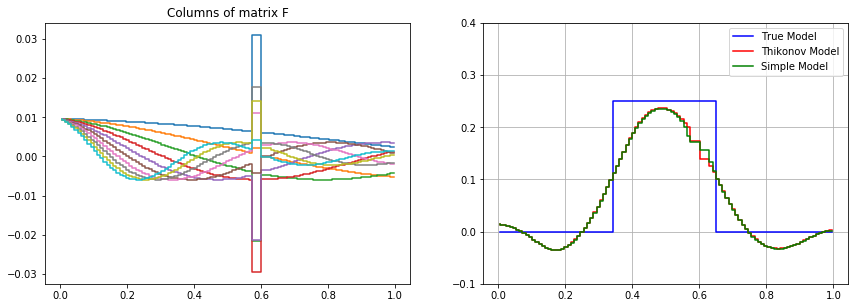

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12*1.2, 4*1.2))
for i in range(prob.F.shape[0]):
    axes[0].step(M.vectorCCx,prob.F[i, :])
axes[0].set_title('Columns of matrix F')

axes[1].step(M.vectorCCx, survey.mtrue, 'b-')
axes[1].step(M.vectorCCx, mrec_Thikonov, 'r-')
axes[1].step(M.vectorCCx, mrec_Simple, 'g-')
axes[1].legend(('True Model', 'Thikonov Model', 'Simple Model'))
axes[1].set_ylim([-0.1, 0.4])
axes[1].grid(True)

plt.savefig('InvModel_1Bigcell_mixWr.png')

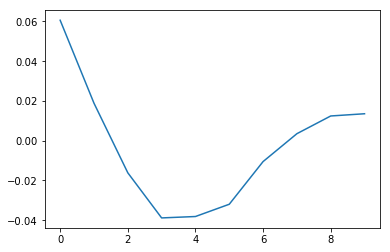

In [7]:
plt.figure()
plt.plot(survey.dobs)